# Comparative Monte Carlo

This script shows how to perform a more advanced comparative Monte Carlo simulation.

We also run Monte Carlo simulation using the background system and not only the foreground one as in the previous notebook.

A comparative Monte Carlo is the type of simulation to be used in comparative LCAs, i.e. in analyses where different alternatives to provide the same Functional Unit are compared. In this comparative case it is important to randomly sample a common technology matrix **A** for all alternatives at each iteration, instead of having a different technology matrix per each alternative at each iteration. This allows for a smaller variance and shorter computational times, but is not possible with e.g. SimaPro. Moreover, this allows to optimally perform the  statistical testing of the results with paired tests, to see if the two alternatives are significantly different from each other or not. 

To better understand this script, I recommend reading read the paper by Henriksson et al. (2015) which is probably the best example of an LCA with comparative Monte Carlo simulation followed by statistical testing for significant differences between alternatives. 

_Henriksson, P. J. G., Rico, A., Zhang, W., Ahmad-Al-Nahid, S., Newton, R., Phan, L. T., … Guinée, J. B. (2015). Comparison of Asian Aquaculture Products by Use of Statistically Supported Life Cycle Assessment. Environmental Science and Technology, 49(24), 14176-14183. [https://doi.org/10.1021/acs.est.5b04634](https://doi.org/10.1021/acs.est.5b04634)_

In [1]:
import brightway2 as bw
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
bw.projects.set_current('advlca23')
bw.databases

Databases dictionary with 5 object(s):
	biosphere3
	ecoinvent 3.9 conseq
	exldb
	testbiosphere
	testdb

In [3]:
db = bw.Database("ecoinvent 3.9 conseq")
ipcc = ('IPCC 2013', 'climate change', 'global warming potential (GWP100)')

In [4]:
# Simple montecarlo on ecoinvent process as we know it. We are using the background system.
mydemand = {db.random(): 1}  # select a random process
lca = bw.LCA(mydemand, ipcc)
lca.lci()
lca.lcia()
lca.score

0.14235463029638945

In [5]:
mc = bw.MonteCarloLCA(mydemand, ipcc)
mc_results = [next(mc) for x in range(100)] # will take a bit of time, we are randomly sampling ecoinvent 100 times

0.14235463029638945

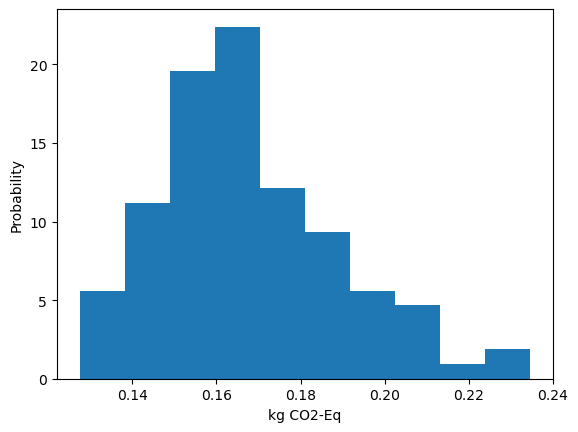

In [6]:
# plot MC results
plt.hist(mc_results, density=True)
plt.ylabel("Probability")
plt.xlabel(bw.methods[ipcc]["unit"])
pd.DataFrame(mc_results).describe() 
lca.score

In [7]:
# Now comparative analysis, select two different transport activities
activity_name = 'transport, freight, lorry >32 metric ton, EURO5'    
for activity in bw.Database("ecoinvent 3.9 conseq"):
    if activity['name'] == activity_name:
        truckE5 = bw.Database("ecoinvent 3.9 conseq").get(activity['code'])

activity_name = 'transport, freight, lorry >32 metric ton, EURO6'    
for activity in bw.Database("ecoinvent 3.9 conseq"):
    if activity['name'] == activity_name:
        truckE6 = bw.Database("ecoinvent 3.9 conseq").get(activity['code'])

In [8]:
# make a list with the alternatives
demands = [{truckE5: 1}, {truckE6: 1}]  # At home, check by using the same process (e.g. truckE5) two times.

mc = bw.MonteCarloLCA(demands[0], ipcc) # We are calculating the impact of transport with the EURO5 truck
next(mc)

0.09892739740701473

In [9]:
# look at this first
mc.redo_lcia(demands[0]) # EURO5 truck
print(mc.score)
mc.redo_lcia(demands[1]) # EURO6 truck. I am using the same technology matrix "A" as before to calcualte results
print(mc.score)
mc.redo_lcia(demands[0]) # EURO5 truck again. Same result. Note how "redo.lcia" allows doing dependent sampling
print(mc.score)

0.09892739740701473
0.1389390146481072
0.09892739740701473


In [10]:
# Now for several iterations
iterations = 100
simulations = [] # empty list that will contain the restuls of all iterations, for all alternatives

for _ in range(iterations):
    #print(_)
    next(mc)
    mcresults = []    # empty list that will contain results for one iteration, for two alteratives
    for i in demands:
        mc.redo_lcia(i)
        mcresults.append(mc.score)
    simulations.append(mcresults) # appends one list to another
    
    
df = pd.DataFrame(simulations, columns = ['truckE5','truckE6']) # df is for "dataframe"
#df.to_csv('ComparativeMCsimulation.csv') # to save it

In [11]:
df

,truckE5,truckE6
0,0.138731,0.119999
1,0.167884,0.094139
2,0.126143,0.132949
3,0.108094,0.092387
4,0.153998,0.141050
...,...,...
95,0.096095,0.128026
96,0.107357,0.098218
97,0.148768,0.101984
98,0.099262,0.137296


<Axes: >

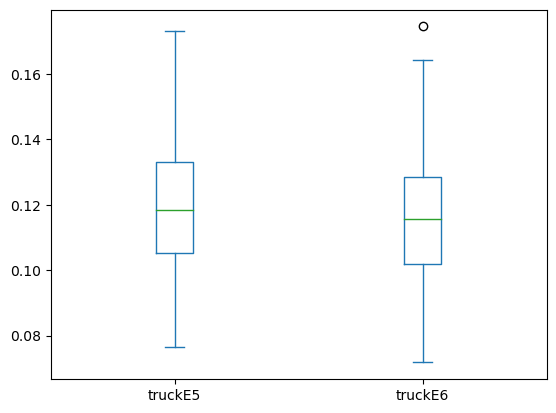

In [12]:
df.plot(kind = 'box')
#df.T.melt()

Text(0, 0.5, 'truckE6 - kg CO2-eq')

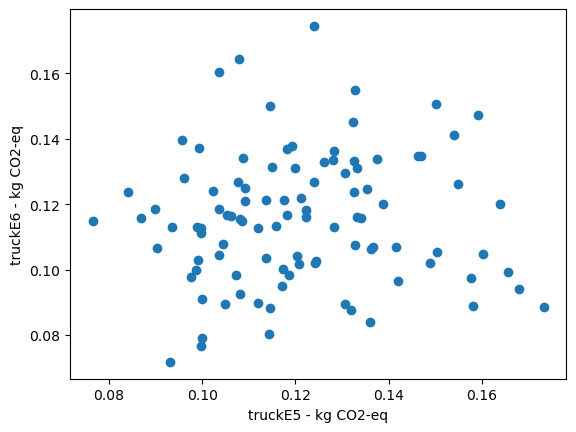

In [13]:
# plot one against the other to see if there is any trend
plt.plot(df.truckE5, df.truckE6, 'o')
plt.xlabel('truckE5 - kg CO2-eq')
plt.ylabel('truckE6 - kg CO2-eq')

47
53
0


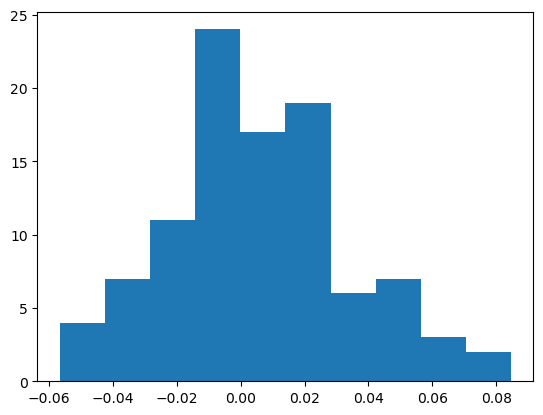

In [14]:
# You can see how many times the difference is positive. This is what Simapro does
df['diffe'] = df.truckE5 - df.truckE6
plt.hist(df.diffe.values)
print(len(df.diffe[df.diffe < 0]))
print(len(df.diffe[df.diffe > 0]))
print(len(df.diffe[df.diffe == 0]))

In [27]:
# Statistical testing (using the stats package)
# I can use a paired t-test

t_value, p_value = stats.ttest_rel(df.truckE5,df.truckE6)
t_value, p_value # Non-significant differnece between the two. 

# In terms og Global Warming the two trucks have basically the same impact considered the uncertainties.

(2.0171711158715007, 0.04638487474892828)

0.07157967984676361
0.6654320359230042


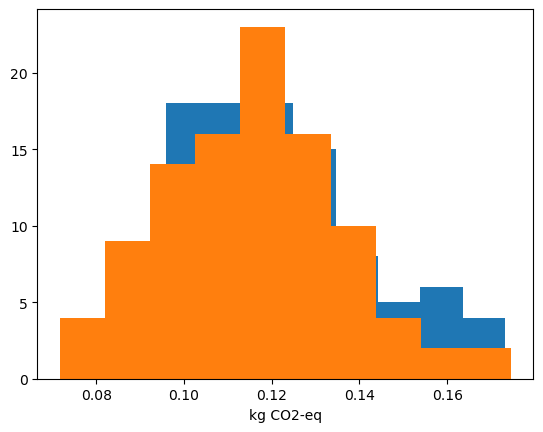

In [29]:
# But wait! did we check for normality?
plt.hist(df.truckE5.values)
plt.xlabel('kg CO2-eq')

SW_value, SW_p_value = stats.shapiro(df.truckE5)
print(SW_p_value) # Low confidence, but seems like it's normally distributed...

plt.hist(df.truckE6.values)
SW_value, SW_p_value = stats.shapiro(df.truckE6)
print(SW_p_value) # This is definitely normally distributed...


In [28]:
# We try anyway a non-parametric test. Wilcox sign rank test
s_value, p_value = stats.wilcoxon(df.truckE5, df.truckE6)
s_value, p_value # Same as before, p > 0.01 

# so we can't really say the differeces are significant given the uncertainties

(2010.0, 0.07660439763601899)

In [18]:
# What if we had done the MC on the processes independently.
mc1 = bw.MonteCarloLCA({truckE5: 1}, ipcc) # truckE5
mc1_results = [next(mc1) for x in range(100)]

mc2 = bw.MonteCarloLCA({truckE5: 1}, ipcc)  # it's still truckE5 !!! I am comparing two times the same activity
mc2_results = [next(mc2) for x in range(100)]

df_ind = pd.DataFrame({'mc1': mc1_results, 'mc2' : mc2_results})

In [19]:
df_ind.head()

,mc1,mc2
0,0.097928,0.127320
1,0.108729,0.124797
2,0.111955,0.100267
3,0.132509,0.136938
4,0.109704,0.150705


In [20]:
# compare to this
demands = [{truckE5: 1}, {truckE5: 1}]  # Two times truckE5! I want to see if the MC results are paired
mc = bw.MonteCarloLCA(demands[0], ipcc)
iterations = 100
simulations = []

for _ in range(iterations):
    next(mc)
    mcresults = []    
    for i in demands:
        mc.redo_lcia(i)
        mcresults.append(mc.score)
    simulations.append(mcresults)
    
    
simulations
df_dep = pd.DataFrame(simulations, columns = ['mc1','mc2'])

In [21]:
df_dep.head()

,mc1,mc2
0,0.094796,0.094796
1,0.097538,0.097538
2,0.123670,0.123670
3,0.099130,0.099130
4,0.110326,0.110326


<Axes: title={'center': 'dependent sampling'}>

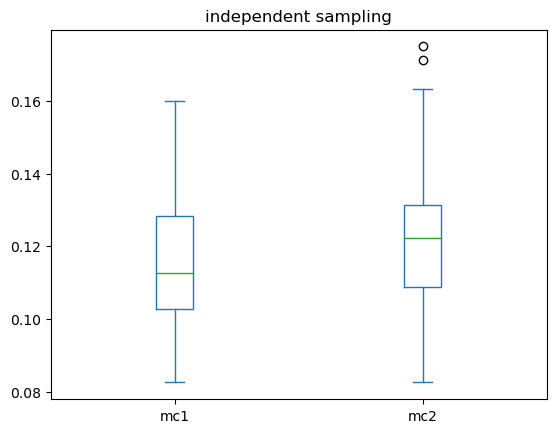

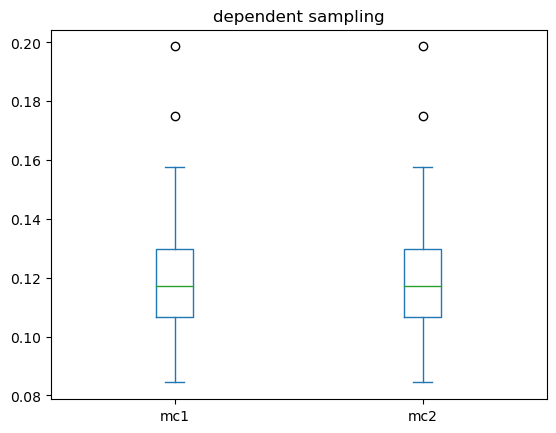

In [22]:
# visual inspection
df_ind.plot(kind = 'box', title = "independent sampling")
df_dep.plot(kind = 'box', title = "dependent sampling")

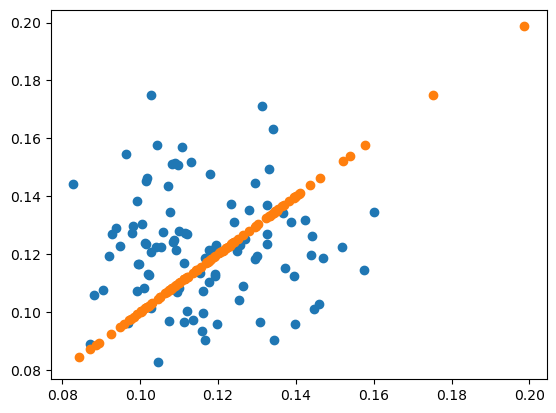

In [23]:
# Plot them together and one against the other
plt.plot(df_ind.mc1, df_ind.mc2, 'o')
plt.plot(df_dep.mc1, df_dep.mc2, 'o') # see?

In [30]:
# and of course:
t_value, p_value = stats.ttest_rel(df_dep.mc1, df_dep.mc2)
print(t_value, p_value)  # no difference AT ALL (as expected)

t_value, p_value = stats.ttest_rel(df_ind.mc1, df_ind.mc2)
print(t_value, p_value)  # no significant difference (as expected!) 

# But still quite some variance even if it's the same process! Because there is uncertainty! 
# This exactly why independent sampling is misleading. You see differences where there is no difference.

s_value, p_value = stats.wilcoxon(df_ind.mc1, df_ind.mc2)
print(s_value, p_value)


nan nan
-2.481816111862137 0.014755347941144603
1873.0 0.02497509022605292


# Additional resources to understand LCA statistics

When applying a statistical approach to LCA, there are some key concepts that is important to understand in detail: distribution types, error propagation, statistical testing. If you are new to statistics, a first step is reading the wikipedia pages explaining [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method), general [statistical hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing), [parametric](https://en.wikipedia.org/wiki/Parametric_statistics) and [nonparametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) statistics, [normality tests](https://en.wikipedia.org/wiki/Normality_test), [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Alternatives_to_the_t-test_for_location_problems), [Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test). When implementing this in Brightway2, it is then useful to read the corresponding python documentation for [statistical functions](https://docs.scipy.org/doc/scipy/reference/stats.html) of the stats package. For example the following functions were used in this script: [Shapiro-Wilk test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro), [paired t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel), and [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon). 

If you want to learn more, buy a good introductory statistics book. Ideally one which has a good balance between mathematical expressions and pedagogic explanations. There are also many open source or free ones, I can recommend e.g. [Statistics](https://en.wikibooks.org/wiki/Statistics) which explains testing in general and it's written in a way which is easy to understand, [The Elements of Data Analytic Style](https://leanpub.com/datastyle) which introduces to data analysis in general, and [Statistical inference for data science](http://leanpub.com/LittleInferenceBook) which is is very practical and especially useful if you also know R. In general I would encourage to learn R too if you plan to work with stats - I honestly prefer it to python for doing statistical analysis and also for plots.



# Check also these
    
#### On Wikipedia

Monte Carlo method 
https://en.wikipedia.org/wiki/Monte_Carlo_method

Normal distribution
https://en.wikipedia.org/wiki/File:Standard_deviation_diagram.svg#/media/File:Standard_deviation_diagram.svg

Parameters of a logrormal distribution
https://en.wikipedia.org/wiki/Log-normal_distribution#/media/File:LogNormal17.jpg


#### On the Brightway website docs

Storing uncertain values
https://2.docs.brightway.dev/intro.html#storing-uncertain-values


#### Papers on this topic (recent ones)

A critique (not very clear tbh but still, a perspective) 
https://pub.epsilon.slu.se/19792/1/von_bromssen_c_et_al_201229.pdf

How many montecarlo runs? 
https://link.springer.com/article/10.1007/s11367-019-01698-4

Ways of doing comparative testing
https://link.springer.com/article/10.1007/s11367-020-01851-4
